## 🧠 Alzheimer's Disease Classification
## The data in total consists of 6400 images.

## In this notebook we apply enhanced Densenet (ANN) Model namely,
* Densenet 121
* Densenet 169

## DenseNet 121

### Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import skimage.io
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D,InputLayer
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

### Loading Data directories

In [3]:
base_dir = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


### Data Augmentation to create holisitc dataset

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=False)

Found 6400 images belonging to 4 classes.


In [5]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


### Performing over-sampling of the data, since the classes are imbalanced

In [6]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


### Splitting the data into train, test, and validation sets

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Loading Pre-Trained Model

In [8]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(input_shape=(176,176,3), 
                         include_top=False,
                         weights="imagenet")

29084464/29084464 [==============================] - 0s 0us/step


### Freezing Layers

In [9]:
for layer in base_model.layers:
    layer.trainable=False

### Model Building 

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential


model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 5, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 batch_normalization (BatchN  (None, 25600)            102400    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              26215424  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

### Data Visualization

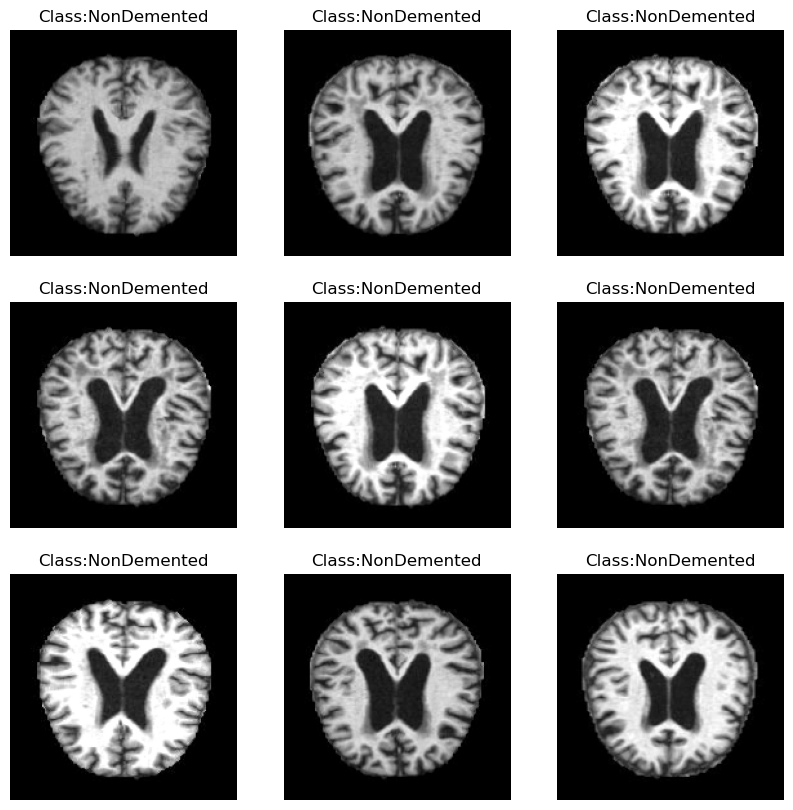

In [11]:
import matplotlib.pyplot as plt
from random import randint, random
import numpy as np
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 31)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

### Adding Model Optimizers, Model Metrics and Loss Function

In [12]:
import tensorflow as tf
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

### Fit the training data to the model and validate it using the validation data

In [13]:
EPOCHS = 5
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/5


2023-04-02 09:17:28.481415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 33s 73ms/step - loss: 0.8778 - auc: 0.8904 - val_loss: 0.4934 - val_auc: 0.9553
Epoch 2/5
256/256 [==============================] - 17s 67ms/step - loss: 0.5228 - auc: 0.9529 - val_loss: 0.3615 - val_auc: 0.9753
Epoch 3/5
256/256 [==============================] - 15s 57ms/step - loss: 0.4027 - auc: 0.9708 - val_loss: 0.3355 - val_auc: 0.9792
Epoch 4/5
256/256 [==============================] - 15s 58ms/step - loss: 0.3473 - auc: 0.9777 - val_loss: 0.3059 - val_auc: 0.9828
Epoch 5/5
256/256 [==============================] - 17s 66ms/step - loss: 0.3026 - auc: 0.9830 - val_loss: 0.2575 - val_auc: 0.9876


### Model Evaluation

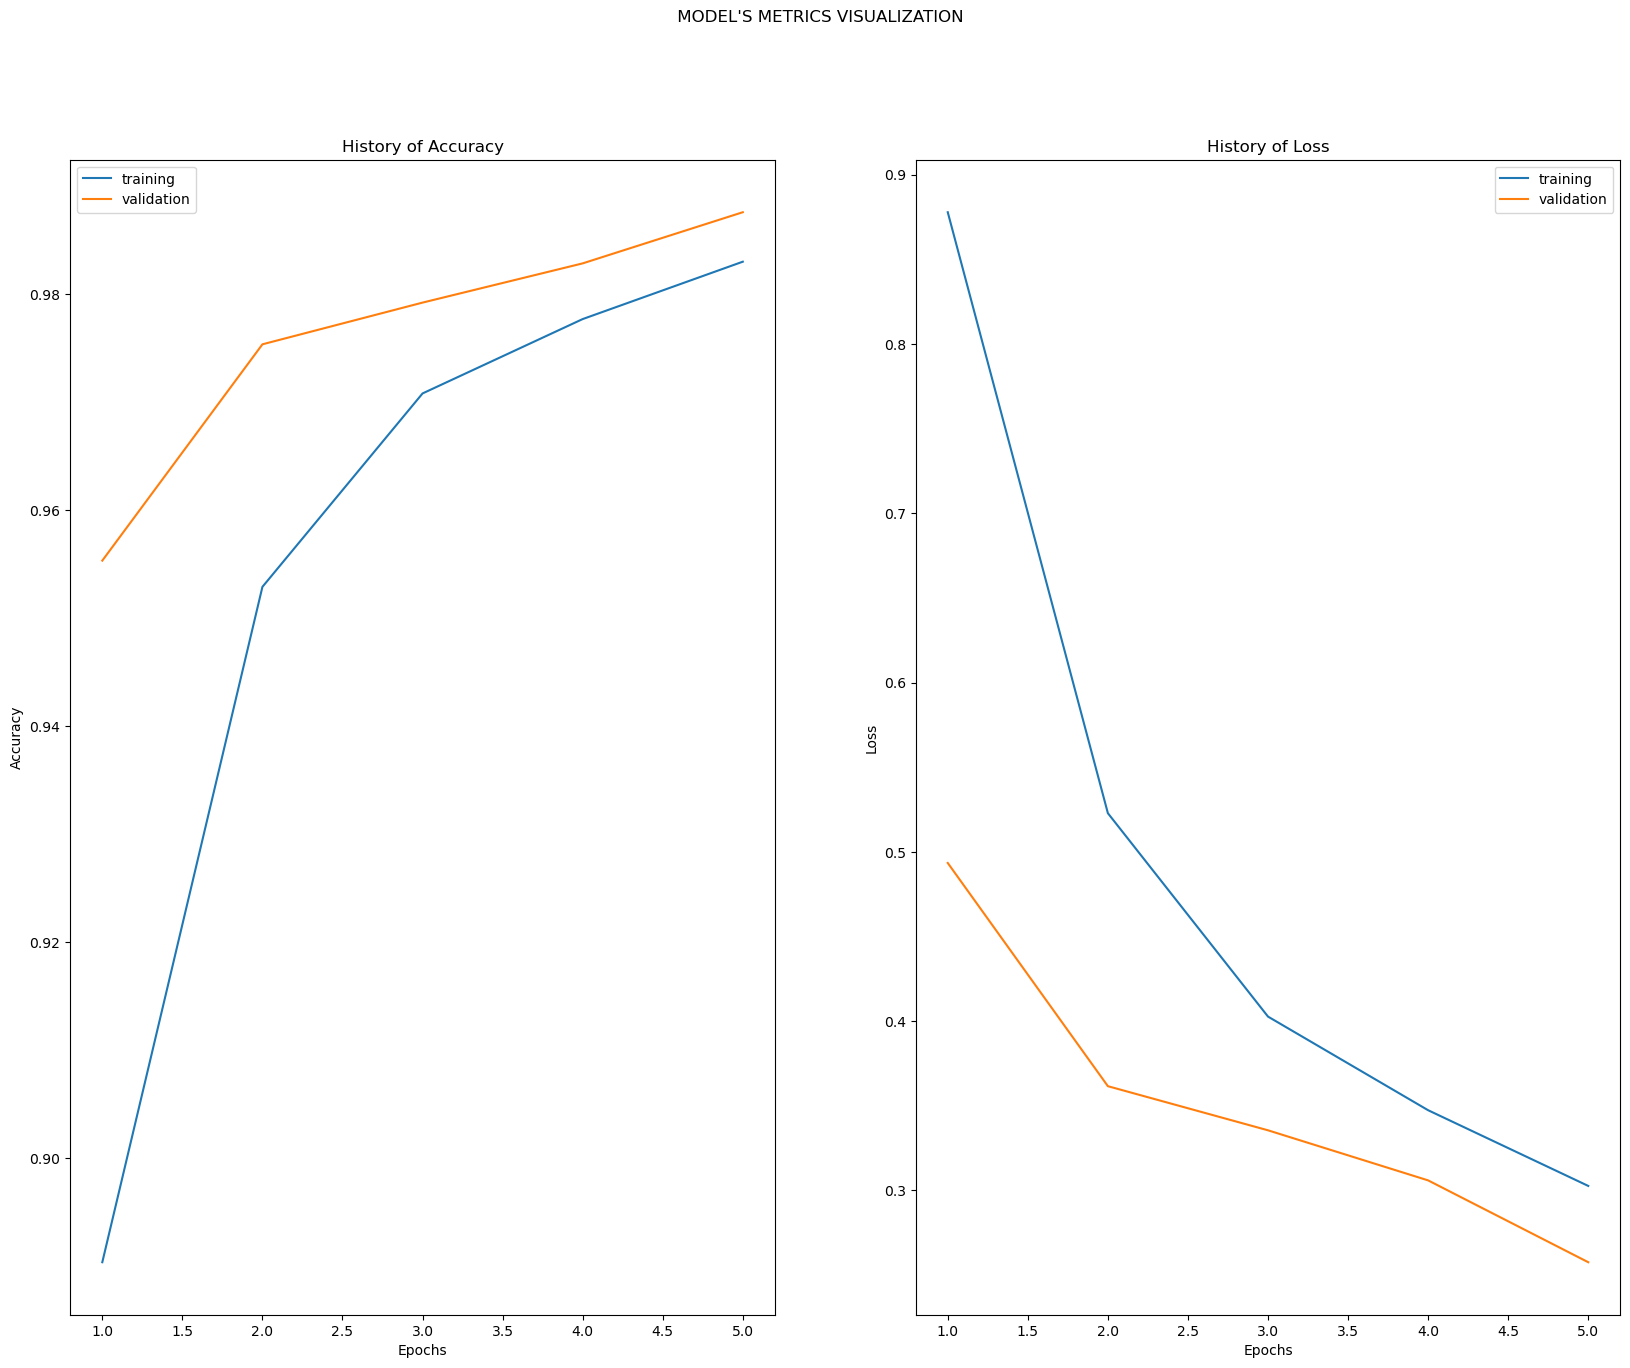

In [14]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['auc'],history.history['val_auc'],
               history.history['loss'],history.history['val_loss'])

### Model Report

In [15]:
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)


print(classification_report(test_labels, pred_labels, target_names=CLASSES))

80/80 [==============================] - 5s 41ms/step
                  precision    recall  f1-score   support

     NonDemented       0.91      0.98      0.94       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.86      0.84      0.85       662
ModerateDemented       0.85      0.81      0.83       624

       micro avg       0.91      0.91      0.91      2560
       macro avg       0.90      0.91      0.90      2560
    weighted avg       0.90      0.91      0.90      2560
     samples avg       0.91      0.91      0.91      2560



### Model Accuracy

In [16]:
from sklearn.metrics import roc_auc_score
print("Accuracy is",roc_auc_score(test_labels, pred_labels))

Accuracy is 0.9367964767963354


### Plot the confusion matrix to understand the classification in detail

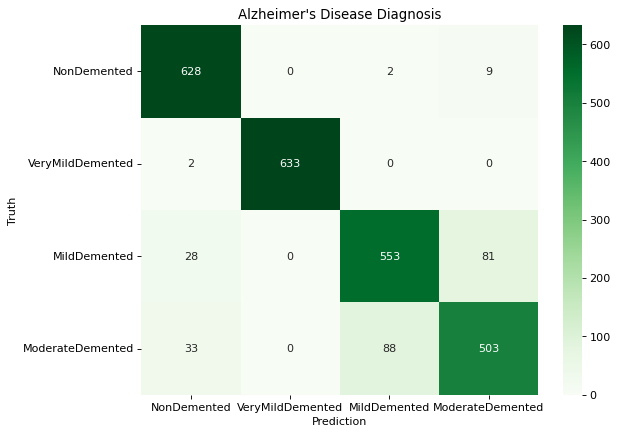

In [17]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

## DensetNet 169 Model

### IMPORT / VIEWING / PREPROCESSING DATASET
### DATA AUGMENTATION

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

### Creating Dataset Batches (Train, Test, Validation)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


In [7]:
test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


### Data & Data Label Visualization

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


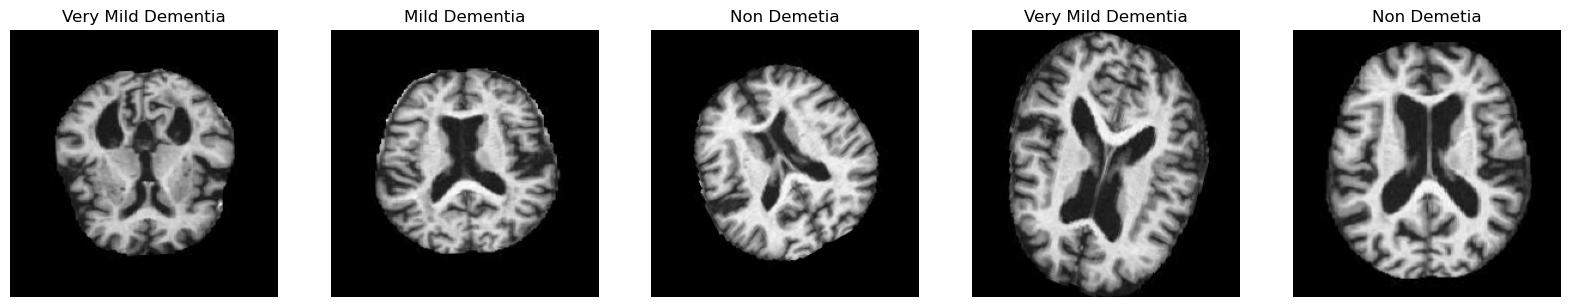

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### Model Initialization

In [9]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 2s 0us/step


### Freezing Layers

In [10]:
for layer in base_model.layers:
    layer.trainable=False

### Building Model

In [11]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

### Adding Loss function and metrics

In [12]:
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

### Adding Early Stopping and Model Checkpoint

In [13]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

### Fitting the model

In [14]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 40,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/40


2023-04-02 13:17:03.853592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - ETA: 0s - loss: 1.3358 - auc: 0.7860
Epoch 1: val_auc improved from -inf to 0.63414, saving model to ./best_weights.hdf5
33/33 [==============================] - 96s 2s/step - loss: 1.3358 - auc: 0.7860 - val_loss: 5.5894 - val_auc: 0.6341
Epoch 2/40
33/33 [==============================] - ETA: 0s - loss: 1.0841 - auc: 0.8336
Epoch 2: val_auc improved from 0.63414 to 0.73136, saving model to ./best_weights.hdf5
33/33 [==============================] - 64s 2s/step - loss: 1.0841 - auc: 0.8336 - val_loss: 2.1055 - val_auc: 0.7314
Epoch 3/40
33/33 [==============================] - ETA: 0s - loss: 0.9600 - auc: 0.8532
Epoch 3: val_auc improved from 0.73136 to 0.74543, saving model to ./best_weights.hdf5
33/33 [==============================] - 67s 2s/step - loss: 0.9600 - auc: 0.8532 - val_loss: 1.7410 - val_auc: 0.7454
Epoch 4/40
33/33 [==============================] - ETA: 0s - loss: 0.9482 - auc: 0.8551
Epoch 4: val_auc did not improve from 0.

### Model Evaluation
### Summarize history for loss

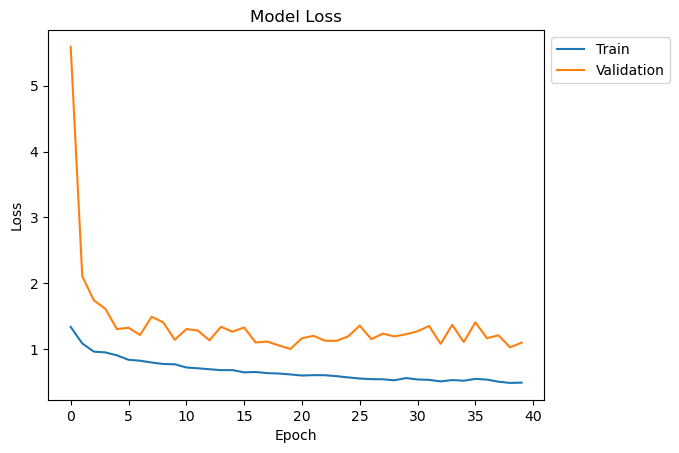

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

### Summarize history for Accuracy

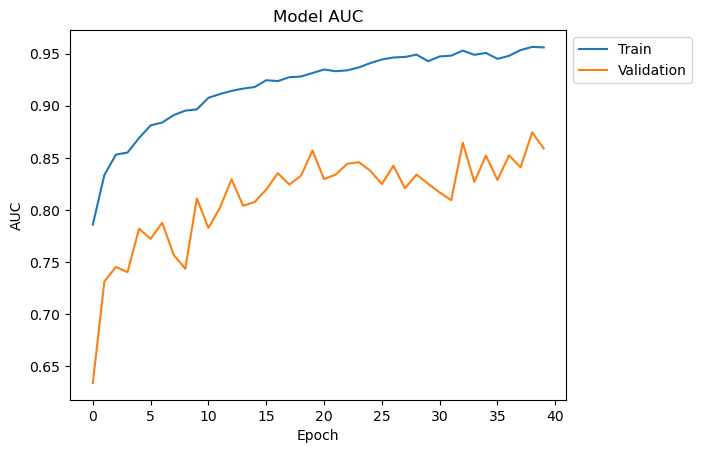

In [16]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

### Model's Test Accuracy

In [17]:
output = model.evaluate(test_dataset)
print("Loss:",output[0])
print("Test Accuracy:",output[1])

10/10 [==============================] - 8s 863ms/step - loss: 1.0398 - auc: 0.8817
Loss: 1.0398197174072266
Test Accuracy: 0.8817299604415894


### Model Predictions
### For Test Case 1: Non-Dementia

1/1 [==============================] - 0s 70ms/step
99.63 % chances are there that the image is NonDemented


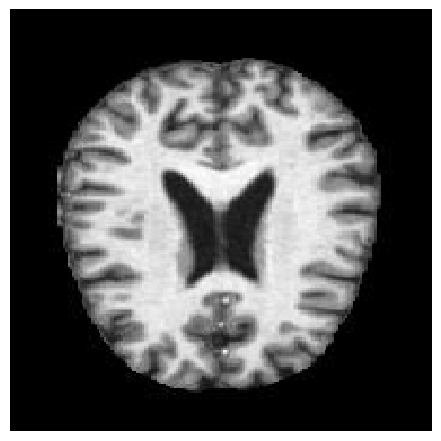

In [29]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
# answer = model.predict_classes(img)
predict_x=model.predict(img) 
answer=np.argmax(predict_x,axis=1)
probability = round(np.max(predict_x*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

### For Test Case 2: Mild Demented

1/1 [==============================] - 0s 66ms/step
86.19 % chances are there that the image is MildDemented


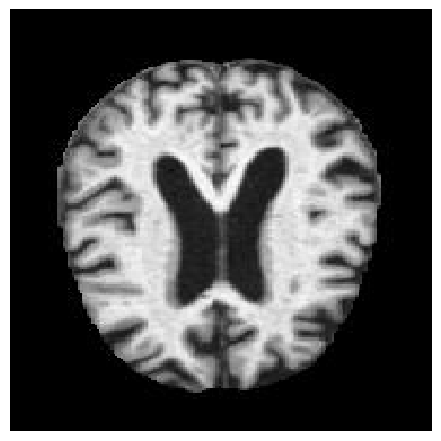

In [33]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
predict_x=model.predict(img) 
answer=np.argmax(predict_x,axis=1)
probability = round(np.max(predict_x*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

### Test Case 3: Moderate Demented

1/1 [==============================] - 0s 61ms/step
96.88 % chances are there that the image is ModerateDemented


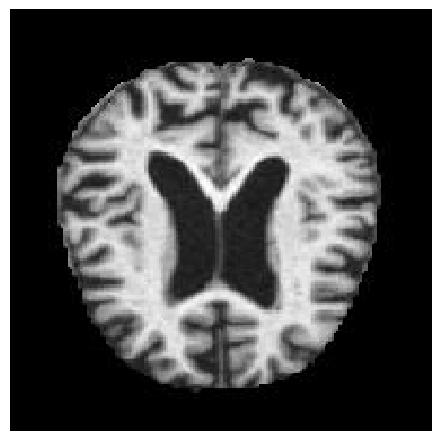

In [34]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
predict_x=model.predict(img) 
answer=np.argmax(predict_x,axis=1)
probability = round(np.max(predict_x*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

### Test Case 4: Very Mild Demented

1/1 [==============================] - 0s 65ms/step
49.1 % chances are there that the image is VeryMildDemented


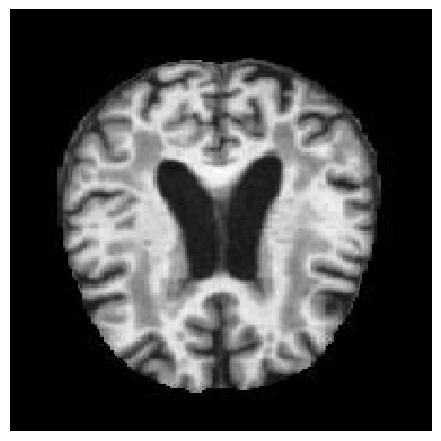

In [35]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
predict_x=model.predict(img) 
answer=np.argmax(predict_x,axis=1)
probability = round(np.max(predict_x*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])